In [0]:
# !pip install pandas

!pip install -U -q PyDrive

     |████████████████████████████████| 993kB 4.7MB/s 


In [0]:
import matplotlib.pyplot as plt
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plot
import sklearn.utils

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC

import warnings
warnings.filterwarnings('ignore')

In [0]:
def ReadFileFromGDrive(sharable_link, file_name, read_local, sheet_index = 0):
  
  if read_local:
    print('Read Sheet index ' , sheet_index)
    return pd.read_excel(file_name, sheet_name  = sheet_index)
  
  # Authenticate and create the PyDrive client.
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

  link = sharable_link # The shareable link

  fluff, id = link.split('=')
  print (id) # Verify that you have everything after '='

  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile(file_name)  
  return pd.read_excel(file_name, sheetname=1)
# --------------------------
def ReadExcel(file_name):
  print('read')
  xlsx = pd.ExcelFile(file_name)
  sheets = []
  print(xlsx.sheet_names)
  for sheet in xlsx.sheet_names:
    sheets.append(xlsx.parse(sheet))
    all_sheets = pd.concat(sheets)
  return all_sheets

In [0]:
students_fired = ReadFileFromGDrive(sharable_link = 'https://drive.google.com/open?id='
                                    ,file_name = 'Ekhraji.xlsx' , read_local= True,sheet_index = 0)

students_fired.shape

Read Sheet index  0


(7074, 31)

In [0]:
students_gheyre_tarke_tahsil = ReadFileFromGDrive(sharable_link = 'https://drive.google.com/open?id='
                                    ,file_name = 'TarkeTahsil_980401.xlsx' , read_local= True,sheet_index = 1)

students_gheyre_tarke_tahsil.shape

Read Sheet index  1


(27669, 31)

In [0]:
students_gheyre_tarke_tahsil.insert(28, 'IsStudying', 1)
students_gheyre_tarke_tahsil.head(3)

,Sex,Shift,RegionCode,SchoolType,SchoolCode,Nationality,Religion,MarriageState,FamilyState,BodyState,FatherJob,FatherMadrak,HouseState,JaheshiRahnamaee,LeftHand,StudentType,MotherJob,StudentState,SoldierState,OstanCode,NumberOfChilds,NoChild,MotherMadrak,HistoryRegionCode,Average,StageType,grade,AverageLabel,IsStudying,OstanName,Name,HistoryRegionName
0,1,1,1101,1,10120813,1,1,0,0,0,1,6,0,0,0,1,4,2,0,11,5,6,5,1101,11.195312,5,1,4,1,شهر تهران,پيام شهيد,تهران ناحيه ١
1,1,1,1101,1,10120813,1,1,0,0,0,1,7,0,0,0,1,4,2,0,11,2,2,6,1101,8.662879,5,1,4,1,شهر تهران,پيام شهيد,تهران ناحيه ١
2,1,1,1101,1,10120813,1,1,0,0,0,1,9,2,0,0,1,4,2,0,11,2,2,6,1101,12.678030,5,1,4,1,شهر تهران,پيام شهيد,تهران ناحيه ١


In [0]:
students_gheyre_tarke_tahsil.iloc[:,27].head(3)

0    4
1    4
2    4
Name: AverageLabel, dtype: int64

In [0]:
students_fired.insert(28, 'IsStudying', 0)
students_fired.head(3)

,Sex,Shift,RegionCode,SchoolType,SchoolCode,Nationality,Religion,MarriageState,FamilyState,BodyState,FatherJob,FatherMadrak,HouseState,JaheshiRahnamaee,LeftHand,StudentType,MotherJob,StudentState,SoldierState,OstanCode,NumberOfChilds,NoChild,MotherMadrak,HistoryRegionCode,Average,StageType,grade,AverageLabel,IsStudying,OstanName,Name,HistoryRegionName
0,1,1,1102,4,95002133,1,1,0,0,0,10,8,0,0,0,1,4,5,0,23,0,0,8,1102,19.136364,5,1,1,0,فارس,سلام,تهران ناحيه ٢
1,1,1,1104,1,10448000,1,1,0,0,0,1,8,0,0,0,1,4,5,0,11,0,0,6,1104,14.522059,5,2,3,0,شهر تهران,شهيدرجائي (م .پ )1,تهران ناحيه ٤
2,1,1,1104,4,10444204,1,1,0,0,0,5,9,0,0,0,1,4,5,0,11,1,1,7,1104,14.411765,5,2,3,0,شهر تهران,المهدي (م .پ )غيرانتفاعي,تهران ناحيه ٤


In [0]:
all_students = sklearn.utils.shuffle(pd.concat([students_fired, students_gheyre_tarke_tahsil.sample(n = 7024)], ignore_index=True))

print(all_students.shape)

all_students = all_students.drop('StudentState', axis = 1)

all_students.head(3)

(14098, 32)


,Sex,Shift,RegionCode,SchoolType,SchoolCode,Nationality,Religion,MarriageState,FamilyState,BodyState,FatherJob,FatherMadrak,HouseState,JaheshiRahnamaee,LeftHand,StudentType,MotherJob,SoldierState,OstanCode,NumberOfChilds,NoChild,MotherMadrak,HistoryRegionCode,Average,StageType,grade,AverageLabel,IsStudying,OstanName,Name,HistoryRegionName
6779,2,1,5131,1,64112906,1,1,0,0,0,3,4,0,0,0,1,4,0,51,2,5,1,5131,10.155303,5,1,4,0,بوشهر,فاطميه,دشتي
12167,2,2,2759,1,27334003,1,1,0,0,0,5,2,0,0,0,1,4,0,27,6,7,3,2759,10.742424,5,1,4,1,گلستان,مطهره,گنبدکاووس
10273,1,1,3808,1,70305609,1,1,0,0,0,5,5,0,0,0,1,4,0,38,1,5,4,3808,13.916667,4,3,3,1,کرمان,شهيد صدوقي,راور


In [0]:
def Normalize_Column(data, target_columns):
  for target in target_columns:
    data[target]=((data[target]-data[target].min())/(data[target].max()-data[target].min()))*20
  return data

In [0]:
hm_input = all_students.iloc[:,0:28]
hm_input  = Normalize_Column(hm_input, ['Sex','Shift','RegionCode','SchoolType','SchoolCode','Nationality','Religion','MarriageState','FamilyState',
                                        'BodyState','FatherJob','FatherMadrak','HouseState','LeftHand','StudentType','MotherJob','SoldierState',
                                        'OstanCode','NumberOfChilds','NoChild','MotherMadrak','HistoryRegionCode'])
# -----------------------------------------------
print(hm_input.shape)
hm_input.head(3)

(14098, 28)


,Sex,Shift,RegionCode,SchoolType,SchoolCode,Nationality,Religion,MarriageState,FamilyState,BodyState,FatherJob,FatherMadrak,HouseState,JaheshiRahnamaee,LeftHand,StudentType,MotherJob,SoldierState,OstanCode,NumberOfChilds,NoChild,MotherMadrak,HistoryRegionCode,Average,StageType,grade,AverageLabel,IsStudying
6779,20.0,0.0,9.672387,0.0,12.700075,0.0,6.666667,0.0,0.0,0.0,2.857143,6.0,0.0,0,0.0,0.0,4.285714,0.0,9.761905,4.0,10.0,0.0,9.672387,10.155303,5,1,4,0
12167,20.0,10.0,3.979359,0.0,4.048936,0.0,6.666667,0.0,0.0,0.0,5.714286,2.0,0.0,0,0.0,0.0,4.285714,0.0,4.047619,12.0,14.0,4.0,3.979359,10.742424,5,1,4,1
10273,0.0,0.0,6.497060,0.0,14.156724,0.0,6.666667,0.0,0.0,0.0,5.714286,8.0,0.0,0,0.0,0.0,4.285714,0.0,6.666667,2.0,10.0,6.0,6.497060,13.916667,4,3,3,1


Highly correlated features to IsStudying:


IsStudying      1.000000
Average         0.502979
AverageLabel    0.357653
grade           0.278328
MotherMadrak    0.216333
FatherMadrak    0.209603
FatherJob       0.198084
Sex             0.185770
SchoolCode      0.162730
StageType       0.143007
Shift           0.133816
NoChild         0.118968
Name: IsStudying, dtype: float64

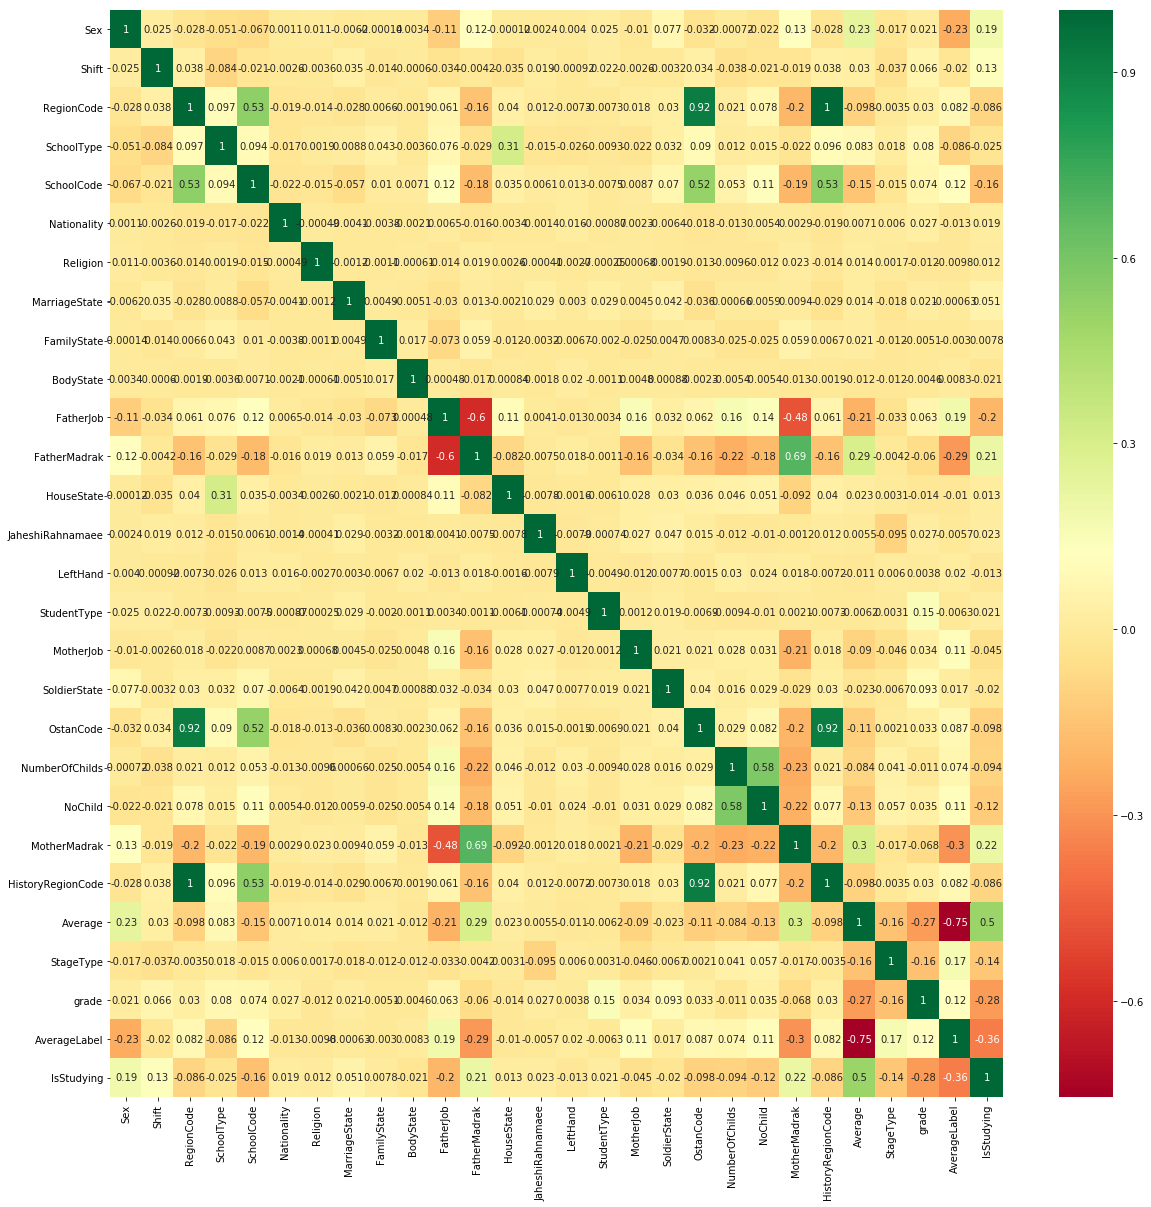

In [0]:
# Create HeatMap
X = hm_input.iloc[:,0:28]  #independent columns
y = hm_input['IsStudying']   #target column

#get correlations of each features in dataset
students_corr = hm_input.corr()
top_corr_features = students_corr.index
plot.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(hm_input[top_corr_features].corr(),annot=True,cmap="RdYlGn")
# plot.show()
plt.savefig('1.png', bbox_inches='tight')

# -----------------------------------------------
#Correlation with output variable
cor_target = abs(students_corr["IsStudying"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target>=0.1]

print('Highly correlated features to IsStudying:')

relevant_features.sort_values(ascending= False)

In [0]:
# Get Label for Sex Enum
def Label_Sex (row):
  target_item = 'Sex'  
  if row[target_item] == 1 :
    return 'Boy'
  if row[target_item] == 2 :
    return 'Girl'
  return 'NAN'
# -----------------------------------------------------
# Get Label for Shift Enum
def Label_Shift (row):
  target_item = 'Shift'  
  if row[target_item] == 1 :
    return 'صبح'
  if row[target_item] == 2 :
    return 'عصر'
  return 'NAN'
# -----------------------------------------------------
# Get Label for Nationality Enum
def Label_Nationality (row):
  target_item = 'Nationality'    
  if row[target_item] == 1 :
    return 'ايران'
  if row[target_item] == 2 :
    return 'افغانستان'
  if row[target_item] == 3 :
    return 'عراق'
  if row[target_item] == 4 :
    return 'ترکيه'
  if row[target_item] == 5 :
    return 'پاکستان'
  if row[target_item] == 6 :
    return 'ترکمنستان'
  if row[target_item] == 7 :
    return 'تاجيکستان'
  if row[target_item] == 8 :
    return 'آذربايجان'
  if row[target_item] == 9 :
    return 'حوزه خليج فارس وعمان'
  if row[target_item] == 10 :
    return 'سايرکشورهاي عربي'
  if row[target_item] == 11 :
    return 'آسياي شرقي'
  if row[target_item] == 12 :
    return 'سايرآسيا'
  if row[target_item] == 13 :
    return 'اروپا'
  if row[target_item] == 14 :
    return 'استراليا'
  if row[target_item] == 15 :
    return 'آفريقا'
  if row[target_item] == 16 :
    return 'قاره آمريکا'
  if row[target_item] == 17 :
    return 'ساير کشورها'
  if row[target_item] == 19 :
    return 'ایراني فاقد شناسنامه'  
  if row[target_item] == 20 :
    return 'نا مشخص'  

  return 'NAN'
# -----------------------------------------------------
# Get Label for Religion Enum
def Label_Religion (row):
  target_item = 'Religion'  
  if row[target_item] == 1 :
    return 'اسلام'
  if row[target_item] == 2 :
    return 'مسیحی'
  if row[target_item] == 3 :
    return 'کلیمی'
  if row[target_item] == 4 :
    return 'زرتشتی'  
  return 'NAN'
# -----------------------------------------------------
# Get Label for MarriageState Enum
def Label_MarriageState (row):
  target_item = 'MarriageState'  
  if row[target_item] == 0 :
    return 'مجرد'
  if row[target_item] == 1 :
    return 'متاهل'
  if row[target_item] == 2 :
    return 'معیل'
  if row[target_item] == 3 :
    return 'متکفل' 
  return 'NAN'
# -----------------------------------------------------
# Get Label for FamilyState Enum
def Label_FamilyState (row):
  target_item = 'FamilyState'  
  if row[target_item] == 0 :
    return 'عادي'
  if row[target_item] == 1 :
    return 'فرزند شهيد'
  if row[target_item] == 2 :
    return 'فرزندجانبازتا50'
  if row[target_item] == 3 :
    return 'فرزندجانباز 50 تا70' 
  if row[target_item] == 4 :
    return 'جانباز 70 به بالا'
  if row[target_item] == 5 :
    return 'فرزند آزاده'
  if row[target_item] == 6 :
    return 'فرزند مفقودالاثر'
  if row[target_item] == 9 :
    return 'فرند رزمنده'
  if row[target_item] == 7 :
    return 'فرزند ایثارگر'  
  return 'NAN'
# -----------------------------------------------------
# Get Label for BodyState Enum
def Label_BodyState (row):
  target_item = 'BodyState'  
  if row[target_item] == 0 :
    return 'سالم'
  if row[target_item] == 1 :
    return 'دارای معلولیت'
  return 'NAN'
# -----------------------------------------------------
# Get Label for Job Enum
def Label_Job (row, target_item):
  if row[target_item] == 1 :
    return 'فرهنگي'
  if row[target_item] == 2 :
    return 'نظامي و انتظامي'
  if row[target_item] == 3 :
    return 'بهداشتي و درماني'
  if row[target_item] == 4 :
    return 'خانه دار'
  if row[target_item] == 5 :
    return 'ساير کارمندان دولت'
  if row[target_item] == 6 :
    return 'آزاد تجاري'
  if row[target_item] == 7 :
    return 'آزاد صنعتي'
  if row[target_item] == 8 :
    return 'کشاورزي يا دامداري'
  if row[target_item] == 9 :
    return 'آزاد هنري و خدماتي'
  if row[target_item] == 10 :
    return 'کارمند موسسه غير دولتي'
  if row[target_item] == 11 :
    return 'کارگر ساده'
  if row[target_item] == 12 :
    return 'بازنشسته'
  if row[target_item] == 13 :
    return 'بيکار'
  if row[target_item] == 14 :
    return 'فوت کرده'
  if row[target_item] == 15 :
    return 'ساير'
  return 'NAN'
# -----------------------------------------------------
# Get Label for Madrak Enum
def Label_Madrak (row, target_item):
  if row[target_item] == 1 :
    return 'Bisavad'#'بيسواد'
  if row[target_item] == 2 :
    return 'Tahsilat-Ghadim'#'تحصيلات قديم'
  if row[target_item] == 3 :
    return 'Nehzat'#'مقدماتي نهضت'
  if row[target_item] == 4 :
    return 'Ebtedaee'#'ابتدايي'
  if row[target_item] == 5 :
    return 'Sikl'#'راهنمايي/سيکل'
  if row[target_item] == 6 :
    return 'Diplom'#'ديپلم'
  if row[target_item] == 7 :
    return 'FoghDiplom'#'فوق دیپلم'
  if row[target_item] == 8 :
    return 'Lisance'#'ليسانس'
  if row[target_item] == 9 :
    return 'FoghLisance'#'فوق ليسانس'
  if row[target_item] == 10 :
    return 'Phd'#'دکتری'
  if row[target_item] == 11 :
    return 'Hozavi'#'تحصيلات حوزوي'
  return 'NAN'
# -----------------------------------------------------
# Get Label for HouseState Enum
def Label_HouseState (row, target_item):
  if row[target_item] == 0:
    return 'باخانواده-شخصي'
  if row[target_item] == 1 :
    return 'باخانواده-اجاره'
  if row[target_item] == 2 :
    return 'باخانواده-سازماني'
  if row[target_item] == 3 :
    return 'باخانواده-ساير'
  if row[target_item] == 4 :
    return 'خوابگاه دانش آموزي'
  if row[target_item] == 5 :
    return 'منزل بستگان'
  if row[target_item] == 6 :
    return 'منزل اجاره اي'
  if row[target_item] == 7 :
    return 'ساير'
  if row[target_item] == 8 :
    return 'عشاير'
  return 'NAN'
# -----------------------------------------------------
# Get Label for StudentType Enum
def Label_StudentType (row, target_item):
  if row[target_item] == 1 :
    return 'عادي'
  if row[target_item] == 2 :
    return 'داوطلب آزاد'
  if row[target_item] == 3 :
    return 'مشمول بند 3-5 شیوه نامه تطبیق'
  if row[target_item] == 4 :
    return 'تطبیق معدل دار'
  if row[target_item] == 5 :
    return 'تیز هوش'
  return 'NAN'
# -----------------------------------------------------
# Get Label for StudentState Enum
def Label_StudentState (row, target_item):
  if row[target_item] == 1 :
    return 'فعال'
  if row[target_item] == 2 :
    return 'انتقال رفته'
  if row[target_item] == 3 :
    return 'ضمن سال رفته'
  if row[target_item] == 4 :
    return 'ترک تحصيل'
  if row[target_item] == 5 :
    return 'اخراجي'
  if row[target_item] == 6 :
    return 'مهمان آمده'
  if row[target_item] == 7 :
    return 'مهمان رفته'
  if row[target_item] == 8 :
    return 'فارغ التحصيل'
  if row[target_item] == 9 :
    return 'فارغ التحصيل تاييد شده'
  if row[target_item] == 10 :
    return 'فوت شده'
  if row[target_item] == 11 :
    return 'فارغ التحصيل تاييد شده  از جانب سیستم متمرکز منطقه'
  if row[target_item] == 12 :
    return 'وقفه تحصيلي'
  if row[target_item] == 13 :
    return 'انتقال آمده'
  return 'NAN'

# -----------------------------------------------------
# Get Label for SoldierState Enum
def Label_SoldierState (row, target_item):
  if row[target_item] == 0:
    return 'به سن مشموليت نرسيده'
  if row[target_item] == 1 :
    return 'داراي معافيت تحصيلي'
  if row[target_item] == 2 :
    return 'داراي دفترچه آماده به خدمت'
  if row[target_item] == 3 :
    return 'داراي کارت پايان خدمت'
  if row[target_item] == 4 :
    return 'معافيت دايم'
  if row[target_item] == 5 :
    return 'معافيت موقت'
  if row[target_item] == 6 :
    return 'پرسنل نيروهاي نظامي'
  if row[target_item] == 7 :
    return 'در حال خدمت وظيفه عمومي'
  return 'NAN'

# -----------------------------------------------------
# Get Label for AverageLabel Enum
def Label_AverageLabel (row, target_item):
  if row[target_item] == 1:
    return 'VGO'# very good
  if row[target_item] == 2 :
    return 'GOO'# good
  if row[target_item] == 3 :
    return 'ACC' #acceptable
  if row[target_item] == 4 :
    return 'NME'# Need more effort
  return 'NAN'
# -----------------------------------------------------
# Get Label for Job Enum
def Label_SchoolType (row, target_item):
  if row[target_item] == 1 :
    return 'عادي'
  if row[target_item] == 2 :
    return 'نمونه دولتی'
  if row[target_item] == 3 :
    return 'نمونه مردمي'
  if row[target_item] == 4 :
    return 'غيرانتفاعي'
  if row[target_item] == 5 :
    return 'ايثارگران'
  if row[target_item] == 6 :
    return 'شاهد'
  if row[target_item] == 7 :
    return 'عشايري'
  if row[target_item] == 8 :
    return 'شبانه روزي'
  if row[target_item] == 9 :
    return 'ساير'
  if row[target_item] == 10 :
    return 'استعدادهاي درخشان'
  if row[target_item] == 11 :
    return 'نهضت سواد آموزی'
  if row[target_item] == 12 :
    return 'بزرگسالان'
  if row[target_item] == 13 :
    return 'مشارکت مردمي'
  if row[target_item] == 15 :
    return 'وابسته'
  if row[target_item] == 22 :
    return 'آموزش ازراه دور دولتی'
  if row[target_item] == 23 :
    return 'آموزش ازراه دورغيردولتی'
  if row[target_item] == 19 :
    return 'قيمت تمام شده'
  if row[target_item] == 24 :
    return 'هیات امنایی'
  if row[target_item] == 25 :
    return 'غیر دولتی خیریه'
  if row[target_item] == 26 :
    return 'غیر دولتی عام المنفعه'
  return 'NAN'

# Get Label for StageType Enum
def Label_StageType (row, target_item):
  if row[target_item] == 3:
    return 'Primary school'# ابتدایی
  if row[target_item] == 4 :
    return 'Guidance school'# متوسطه اول
  if row[target_item] == 5 :
    return 'High school' # متوسطه دوم
  return 'NAN'
# ---------------------------------------------

In [0]:
# Add label of sex to dataframe
students_fired['Label_Sex'] = students_fired.apply (lambda row: Label_Sex(row), axis=1)

# Add label of Shift to dataframe
students_fired['Label_Shift'] = students_fired.apply (lambda row: Label_Shift(row), axis=1)

# Add label of Nationality to dataframe
students_fired['Label_Nationality'] = students_fired.apply (lambda row: Label_Nationality(row), axis=1)

# Add label of Religion to dataframe
students_fired['Label_Religion'] = students_fired.apply (lambda row: Label_Religion(row), axis=1)

# Add label of MarriageState to dataframe
students_fired['Label_MarriageState'] = students_fired.apply (lambda row: Label_MarriageState(row), axis=1)

# Add label of FamilyState to dataframe
students_fired['Label_FamilyState'] = students_fired.apply (lambda row: Label_FamilyState(row), axis=1)

# Add label of BodyState to dataframe
students_fired['Label_BodyState'] = students_fired.apply (lambda row: Label_BodyState(row), axis=1)

# Add label of FatherJob to dataframe
students_fired['Label_FatherJob'] = students_fired.apply (lambda row: Label_Job(row,'FatherJob'), axis=1)

# Add label of MotherJob to dataframe
students_fired['Label_MotherJob'] = students_fired.apply (lambda row: Label_Job(row,'MotherJob'), axis=1)

# Add label of FatherMadrak to dataframe
students_fired['Label_FatherMadrak'] = students_fired.apply (lambda row: Label_Madrak(row,'FatherMadrak'), axis=1)

# Add label of MotherMadrak to dataframe
students_fired['Label_MotherMadrak'] = students_fired.apply (lambda row: Label_Madrak(row,'MotherMadrak'), axis=1)

# Add label of HouseState to dataframe
students_fired['Label_HouseState'] = students_fired.apply (lambda row: Label_HouseState(row,'HouseState'), axis=1)

# Add label of StudentType to dataframe
students_fired['Label_StudentType'] = students_fired.apply (lambda row: Label_StudentType(row,'StudentType'), axis=1)

# Add label of StudentState to dataframe
students_fired['Label_StudentState'] = students_fired.apply (lambda row: Label_StudentState(row,'StudentState'), axis=1)

# Add label of SoldierState to dataframe
students_fired['Label_SoldierState'] = students_fired.apply (lambda row: Label_SoldierState(row,'SoldierState'), axis=1)

# Add label of AverageLabel to dataframe
students_fired['Label_AverageLabel'] = students_fired.apply (lambda row: Label_AverageLabel(row,'AverageLabel'), axis=1)

# Add label of SchoolType to dataframe
students_fired['Label_SchoolType'] = students_fired.apply (lambda row: Label_SchoolType(row,'SchoolType'), axis=1)

# Add label of StageType to dataframe
students_fired['Label_StageType'] = students_fired.apply (lambda row: Label_StageType(row,'StageType'), axis=1)

assert students_fired.isnull().values.any() == False

Boy     5419
Girl    1655
Name: Label_Sex, dtype: int64

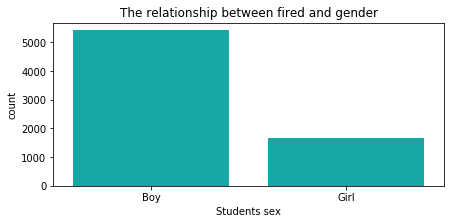

In [0]:
f, ax = plot.subplots(figsize=(7, 3))
chart = sns.countplot(x="Label_Sex", data=students_fired, color="c");
chart.set(xlabel='Students sex', title = 'The relationship between fired and gender')
# plt.show()
plt.savefig('2.png', bbox_inches='tight')

students_fired['Label_Sex'].value_counts()

NME    6234
ACC     642
GOO     112
VGO      86
Name: Label_AverageLabel, dtype: int64

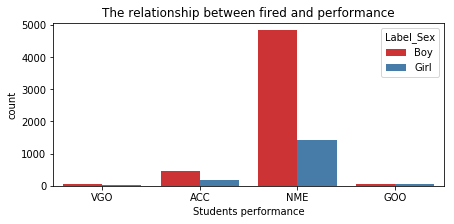

In [0]:
f, ax = plot.subplots(figsize=(7, 3))
chart = sns.countplot(x="Label_AverageLabel", data=students_fired, color="r", hue='Label_Sex', palette="Set1");
chart.set(xlabel='Students performance', title = 'The relationship between fired and performance')
# plt.show()
plt.savefig('3.png', bbox_inches='tight')

students_fired['Label_AverageLabel'].value_counts()

Bisavad            2219
Ebtedaee           2129
Sikl               1089
Diplom              618
Tahsilat-Ghadim     387
Nehzat              269
FoghDiplom          179
Lisance             161
Phd                  10
FoghLisance          10
Hozavi                3
Name: Label_FatherMadrak, dtype: int64

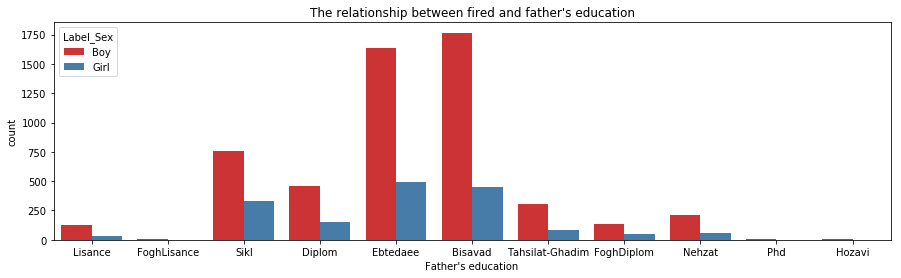

In [0]:
f, ax = plot.subplots(figsize=(15, 4))
chart = sns.countplot(x="Label_FatherMadrak", data=students_fired, color="r", hue='Label_Sex', palette="Set1");
chart.set(xlabel="Father's education", title = "The relationship between fired and father's education")
# plt.show()

plt.savefig('4.png', bbox_inches='tight')

students_fired['Label_FatherMadrak'].value_counts()

,FatherJob,Label_FatherJob,IsStudying
12,13,بيکار,3859
5,6,آزاد تجاري,1111
4,5,ساير کارمندان دولت,903
0,1,فرهنگي,402
6,7,آزاد صنعتي,351
1,2,نظامي و انتظامي,195
2,3,بهداشتي و درماني,84
7,8,کشاورزي يا دامداري,38
14,15,ساير,38
10,11,کارگر ساده,32


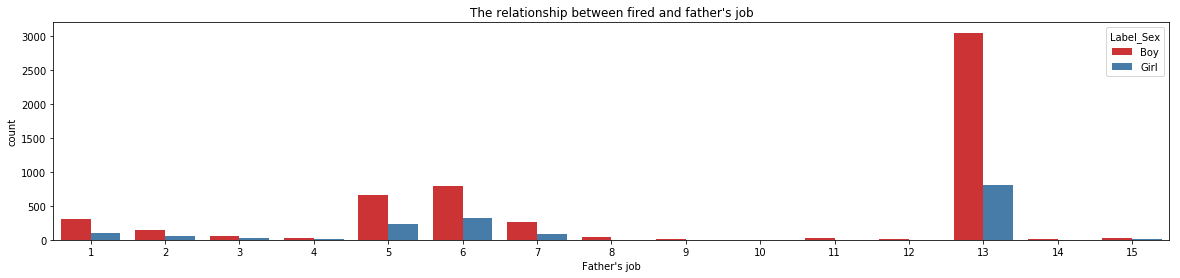

In [0]:
f, ax = plot.subplots(figsize=(20, 4))
chart = sns.countplot(x="FatherJob", data=students_fired, color="r", hue='Label_Sex', palette="Set1");
chart.set(xlabel="Father's job", title = "The relationship between fired and father's job")
# plt.show()
plt.savefig('5.png', bbox_inches='tight')

students_fired[['Label_FatherJob','FatherJob','IsStudying']].groupby(['FatherJob','Label_FatherJob'], as_index=False).count().sort_values(by = 'IsStudying',ascending = False)

High school        7070
Guidance school       4
Name: Label_StageType, dtype: int64

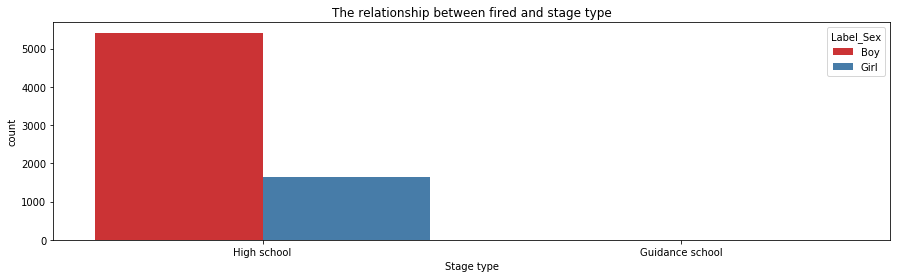

In [0]:
f, ax = plot.subplots(figsize=(15, 4))
chart = sns.countplot(x="Label_StageType", data=students_fired, color="r", hue='Label_Sex', palette="Set1");
chart.set(xlabel='Stage type', title = "The relationship between fired and stage type")
# plt.show()
plt.savefig('6.png', bbox_inches='tight')
students_fired['Label_StageType'].value_counts()

1    3843
3    2986
2     239
9       6
Name: grade, dtype: int64

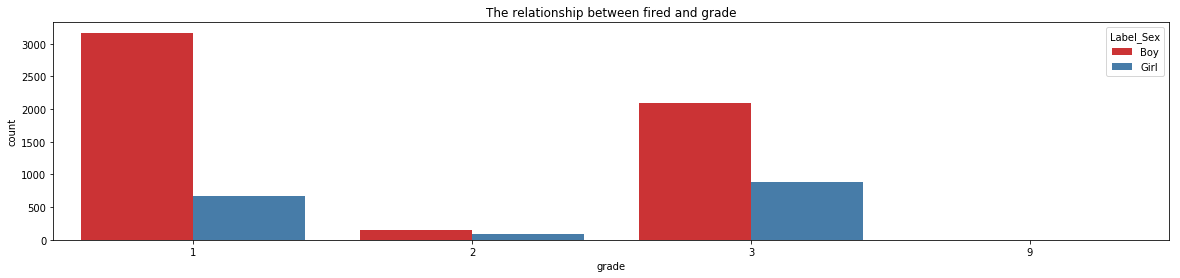

In [0]:
f, ax = plot.subplots(figsize=(20, 4))
chart = sns.countplot(x="grade", data=students_fired, color="r", hue='Label_Sex', palette="Set1");
chart.set(xlabel='grade', title = "The relationship between fired and grade")
# plt.show()

plt.savefig('7.png', bbox_inches='tight')

students_fired['grade'].value_counts()

,OstanCode,OstanName,IsStudying
5,17,اصفهان,1141
4,16,خراسان رضوی,617
11,23,فارس,561
14,29,آذربايجان غربي,520
24,49,سيستان و بلوچستان,495
20,38,کرمان,368
26,51,بوشهر,284
22,44,يزد,281
8,20,مازندران,274
19,37,گيلان,265


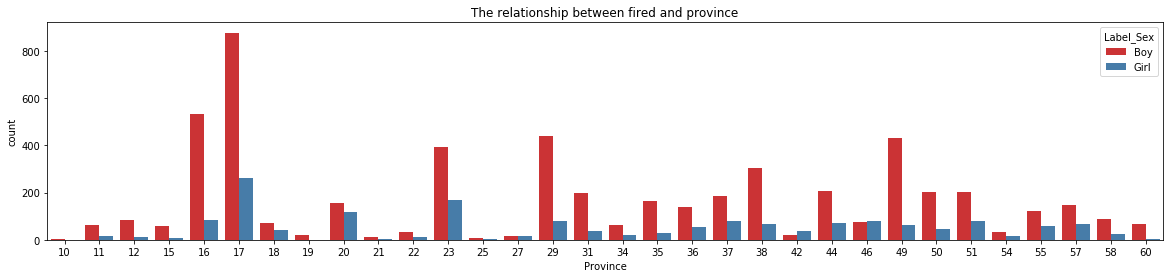

In [0]:
f, ax = plot.subplots(figsize=(20, 4))
chart = sns.countplot(x="OstanCode", data=students_fired, color="r", hue='Label_Sex', palette="Set1");
chart.set(xlabel='Province', title = "The relationship between fired and province")
# plt.show()
plt.savefig('8.png', bbox_inches='tight')

students_fired[['OstanName','OstanCode','IsStudying']].groupby(['OstanCode','OstanName'], as_index=False).count().sort_values(by = 'IsStudying',ascending = False)
